In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/etsydataset/data/.gitkeep
/kaggle/input/etsydataset/data/parquet/test/part-00170-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00049-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00065-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00132-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00146-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00092-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00000-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00184-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00157-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00108-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00274-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00151-of-00278.parquet
/kaggle/input/etsydataset/data/parquet/test/part-00191-of-00278.parquet
/kaggle/input/etsydatase

In [2]:
# libraries
import io
import os
import copy
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

In [3]:
PATH = f"/kaggle/input/etsydataset/data"

In [4]:
!ls -l {PATH}

total 0
drwxr-xr-x 4 nobody nogroup 0 Apr  5 03:44 parquet
drwxr-xr-x 4 nobody nogroup 0 Apr  5 03:44 tfrecords


# Loading Dataset Parquet Files

In [5]:
parquet_filenames_train = !ls -l {PATH}/parquet/train

In [6]:
parquet_filenames_train[:3]

['total 306248',
 '-rw-r--r-- 1 nobody nogroup 2819257 Apr  5 03:45 part-00000-of-00278.parquet',
 '-rw-r--r-- 1 nobody nogroup 2217167 Apr  5 03:45 part-00001-of-00278.parquet']

In [7]:
parquet_filenames_test = !ls -l {PATH}/parquet/test

In [8]:
def get_parquet_data(folder, N):
    """ Read parquet data from mutiple files """

    filenames = [ 
        f"{PATH}/parquet/{folder}/part-{i:05d}-of-{N:05d}.parquet" 
        for i in range(N)
    ]

    dataframes = [ 
        pd.read_parquet(filename) 
        for filename in filenames
    ]
    
    return pd.concat(dataframes)

In [9]:
df_train = get_parquet_data("train", len(parquet_filenames_train)-1)

In [10]:
#print(PATH)
len(parquet_filenames_train)

279

In [11]:
parquet_filenames_test[:3]

['total 38016',
 '-rw-r--r-- 1 nobody nogroup  91327 Apr  5 03:44 part-00000-of-00278.parquet',
 '-rw-r--r-- 1 nobody nogroup 296106 Apr  5 03:45 part-00001-of-00278.parquet']

In [12]:
#df_test = get_parquet_data("test", len(parquet_filenames_test)-1)

In [13]:
#df_test.head()

In [14]:
COLORS = df_train['color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of colors in train: {NUM_COLORS:,}"

'Number of colors in train: 20'

# Loading Dataset TFRecords Files

## TFrecords train 

In [15]:
tfrecord_filenames_train = !ls {PATH}/tfrecords/train

In [16]:
tfrecord_filenames_train[:3]

['part-00000-of-00278.tfrecord',
 'part-00001-of-00278.tfrecord',
 'part-00002-of-00278.tfrecord']

In [17]:
tfrecord_filenames_test = !ls {PATH}/tfrecords/test

In [18]:
tfrecord_filenames_test[:3]

['part-00000-of-00278.tfrecord',
 'part-00001-of-00278.tfrecord',
 'part-00002-of-00278.tfrecord']

In [19]:
tfrecord_filename_train = f"{PATH}/tfrecords/train/{tfrecord_filenames_train[1]}"
raw_dataset_train = tf.data.TFRecordDataset(tfrecord_filename_train)

In [20]:
raw_dataset_train

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [21]:
# Create a description of the features
feature_desc = {
    'product_id': tf.io.FixedLenFeature([], tf.int64),
    'title': tf.io.FixedLenFeature([], tf.string),
    'description': tf.io.FixedLenFeature([], tf.string),
    'tags': tf.io.FixedLenFeature([], tf.string),
    'type': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    # only in training
    'top_category_text': tf.io.FixedLenFeature([], tf.string),
    'bottom_category_text': tf.io.FixedLenFeature([], tf.string),
    'color_text': tf.io.FixedLenFeature([], tf.string)
    
    # more can be added ...
}

In [22]:
def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_desc)

In [23]:
parsed_dataset_train = raw_dataset_train.map(_parse_function)

In [24]:
def get_images(parsed_dataset, column, N=10):
    
    images = []
    titles = []
    for features in parsed_dataset.take(N):
        img_bytes = features['image/encoded'].numpy()
        if column in features:
            text = features[column].numpy().decode('utf-8')
        else:
            text = 'unknown'
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        images.append(image)
        titles.append(text)

    return images, titles

In [25]:
images, titles = get_images(parsed_dataset_train, 'title')

In [26]:
def show(images, titles, N=100):
    
    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows
    
    plt.figure(figsize=(12, plt_height))
    for i, (image, title) in enumerate(zip(images[:N], titles[:N])):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.title(title, fontsize = 12)
        plt.axis("off")
    plt.show()

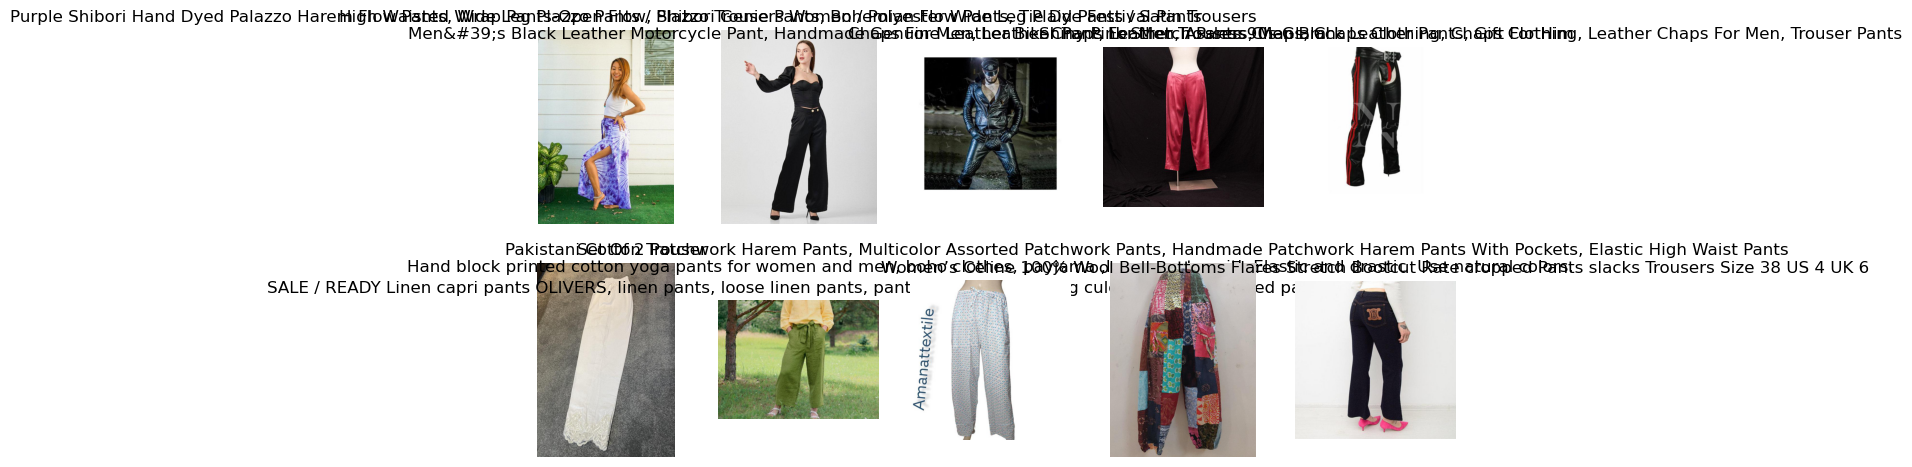

In [27]:
show(images, titles)

## TFRecords Test 

In [28]:
filename = f"{PATH}/tfrecords/test/{tfrecord_filenames_test[1]}"
raw_dataset_test = tf.data.TFRecordDataset(filename)

In [29]:
feature_desc.pop('top_category_text')
feature_desc.pop('bottom_category_text')
feature_desc.pop('color_text')

FixedLenFeature(shape=[], dtype=tf.string, default_value=None)

In [30]:
parsed_dataset_test = raw_dataset_test.map(_parse_function)

In [31]:
images, titles = get_images(parsed_dataset_test, 'title')

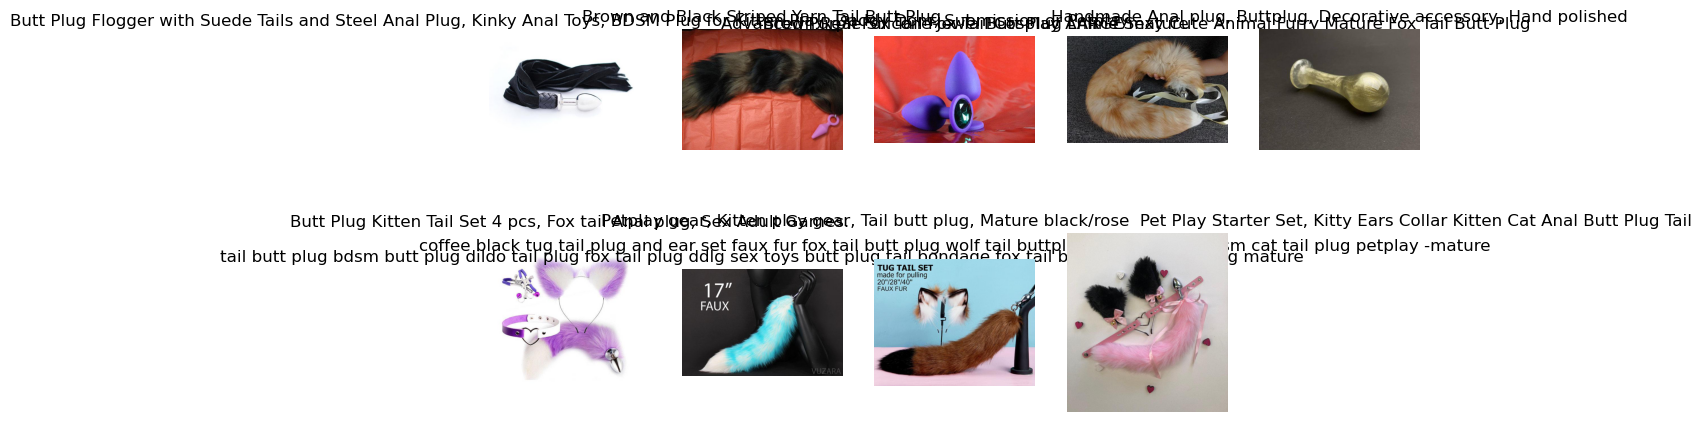

In [32]:
show(images, titles)

# Model Training

As another example, let's train an image classification model to predict color based only on the image as input. We leveraged InceptionV3 as the base model with imagenet weights and freezing the layers. As we are using the TFRecord dataset, we split the filenames into train and validation.

You might want to find a more stratified way to split between train and validation.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
tf_training_filenames, tf_validation_filenames = train_test_split(
    tf.io.gfile.glob(f"{PATH}/tfrecords/train/part-*.tfrecord"),
    test_size=0.2,
    random_state=42,
)

In [35]:
f"Number of TFRecords for training: {len(tf_training_filenames):,}"

'Number of TFRecords for training: 222'

In [36]:
f"Number of TFRecords for testing: {len(tf_validation_filenames):,}"

'Number of TFRecords for testing: 56'

In [37]:
# Create a description of the features.
feature_spec = {
    'product_id': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'color_id': tf.io.FixedLenFeature([], tf.int64),
}

def parse_dataset(example_proto, feature_spec, num_channels):
    
    features = tf.io.parse_single_example(example_proto, feature_spec)
    image_encoded = features["image/encoded"]
    img_width = features["image/width"]
    img_height = features["image/height"]
    color_id = features["color_id"]

    image = tf.reshape(
        tf.io.decode_jpeg(image_encoded),
        [img_height, img_width, num_channels],
    )
    image = tf.cast(image, tf.float32)
    label = tf.cast(tf.one_hot(color_id, NUM_COLORS), tf.int64)

    return (
        { "image": image, },
        label
    )

In [38]:
def create_preprocessing_model(target_image_size, should_rescale):
    preprocessing_layers = []
    if should_rescale:
        preprocessing_layers.append(
            tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
        )
    preprocessing_layers.append(
        tf.keras.layers.experimental.preprocessing.Resizing(
            target_image_size, target_image_size
        )
    )
    return tf.keras.Sequential(preprocessing_layers)

In [39]:
def transform_image_data(example, preprocessing_model):
    image = tf.expand_dims(example["image"], 0)
    example["image"] = preprocessing_model(image)[0]
    return example

In [40]:
def get_dataset_batch(
    file_pattern: [],
    batch_size: int,
    num_channels: int,
    mode: tf.estimator.ModeKeys,
) -> tf.data.Dataset:
    
    augment = shuffle = mode == tf.estimator.ModeKeys.TRAIN

    dataset = tf.data.Dataset.list_files(
        file_pattern, shuffle=shuffle, seed=42
    )
    dataset = dataset.interleave(
        tf.data.TFRecordDataset, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    dataset = dataset.map(
        lambda x: parse_dataset(x, feature_spec, num_channels),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    preprocessing_model = create_preprocessing_model(
        target_image_size=224,
        should_rescale=True,
    )
    dataset = dataset.map(
        lambda x, y: (transform_image_data(x, preprocessing_model), y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [41]:
BATCH_SIZE = 128

In [42]:
train_dataset = get_dataset_batch(
    file_pattern=tf_training_filenames,
    batch_size=BATCH_SIZE,
    num_channels=3,
    mode=tf.estimator.ModeKeys.TRAIN,
)

In [43]:
val_dataset = get_dataset_batch(
    file_pattern=tf_validation_filenames,
    batch_size=BATCH_SIZE,
    num_channels=3,
    mode=tf.estimator.ModeKeys.EVAL,
)

In [44]:
gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [45]:
strategy = tf.distribute.MirroredStrategy()

In [46]:
with strategy.scope():
    
    input_shape = (224, 224, 3)
    inputs = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name="image")
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_COLORS, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

87910968/87910968 [==============================] - 0s 0us/step


In [47]:
for layer in base_model.layers:
    layer.trainable = False

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [49]:
epochs = 3

hist = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1)

Epoch 1/3
1536/1536 [==============================] - 1096s 662ms/step - loss: 2.1721 - accuracy: 0.3539 - val_loss: 2.0473 - val_accuracy: 0.3908
Epoch 2/3
1536/1536 [==============================] - 1027s 669ms/step - loss: 1.9571 - accuracy: 0.4142 - val_loss: 2.0798 - val_accuracy: 0.3879
Epoch 3/3
1536/1536 [==============================] - 1034s 673ms/step - loss: 1.8675 - accuracy: 0.4411 - val_loss: 1.8659 - val_accuracy: 0.4456


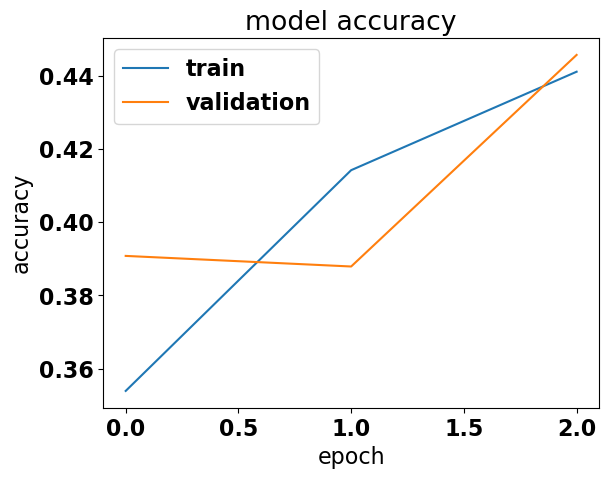

In [50]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [51]:
model.evaluate(val_dataset, batch_size=BATCH_SIZE, verbose=1)

381/381 [==============================] - 146s 382ms/step - loss: 1.8659 - accuracy: 0.4456


[1.8659110069274902, 0.44564059376716614]

In [52]:
predictions = model.predict(val_dataset, batch_size=BATCH_SIZE, verbose=1)

381/381 [==============================] - 150s 378ms/step
